In [205]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints
import math
from math import sin as sin
from math import cos as cos
import time

In [206]:
import pandas as pd


file_path = 'log.csv'

# Einlesen der Datei
df = pd.read_csv(file_path, sep='\t', header=None, names=[
    'Zeit_Index',
    'X_GT', 'Y_GT',
    'Richtung_X_B0', 'Richtung_Y_B0', 'STD_Grad_B0',
    'Richtung_X_B1', 'Richtung_Y_B1', 'STD_Grad_B1',
    'Richtung_X_B2', 'Richtung_Y_B2', 'STD_Grad_B2'
])

#print(df.head())
df

,Zeit_Index,X_GT,Y_GT,Richtung_X_B0,Richtung_Y_B0,STD_Grad_B0,Richtung_X_B1,Richtung_Y_B1,STD_Grad_B1,Richtung_X_B2,Richtung_Y_B2,STD_Grad_B2
0,0,0.000000,-14.860000,-0.897857,0.440288,1,0.011008,0.999939,1,0.899657,0.436598,1
1,1,0.000005,-14.758000,-0.903102,0.429426,1,0.017182,0.999852,1,0.899777,0.436350,1
2,2,0.000015,-14.647070,-0.886780,0.462191,1,0.001937,0.999998,1,0.896675,0.442690,1
3,3,0.000026,-14.520380,-0.907837,0.419323,1,-0.000249,1.000000,1,0.892517,0.451014,1
4,4,0.000040,-14.370980,-0.904075,0.427375,1,-0.028454,0.999595,1,0.898747,0.438468,1
...,...,...,...,...,...,...,...,...,...,...,...,...
196,196,33.995050,-5.852832,-0.828039,-0.560671,1,-0.992162,0.124958,1,-0.962621,0.270853,1
197,197,34.580270,-5.080067,-0.858108,-0.513470,1,-0.983030,0.183446,1,-0.959967,0.280114,1
198,198,35.070080,-4.243696,-0.923957,-0.382496,1,-0.948403,0.317067,1,-0.972063,0.234718,1
199,199,35.447260,-3.351019,-0.965676,-0.259749,1,-0.890567,0.454851,1,-0.974070,0.226247,1


In [207]:

# Main-Funktion
if __name__ == "__main__":

    #std_0 = 1  # Std. für Beacon 0
    #std_1 = 1  # Std. für Beacon 1
    #std_2 = 1 # Std. für Beacon 2
    #std_h = 0.01  # Std. für Kompass
    
    beacon0_pos = np.array([-30, 0])
    beacon1_pos = np.array([0, 30])
    beacon2_pos = np.array([30, 0])

    #samples = 100

    # 10hz dh. 100ms (wie auch in den Logdateien Zeit_Index gewollt)
    dT = 0.1

    np.random.seed(int(time.time()))
    

In [208]:
def f_x(state, dt):
    """
    Zustandsübergangsfunktion.
    Da die Geschwindigkeit konstant ist und der Zustand nur die Position beinhaltet,
    hat diese Funktion einfach die Geschwindigkeit zur Position hinzugefügt.
    TODO: Später Orientierungswinkel rein (und Winkel in der Messfunktion beachten)
    """  
    x, y, vx, vy, ax, ay = state

    # Update position with current velocity and acceleration
    new_x = x + vx * dt + (ax * dt ** 2) / 2.0
    new_y = y + vy * dt + (ay * dt ** 2) / 2.0

    # Update velocity with current acceleration
    new_vx = vx + ax * dt
    new_vy = vy + ay * dt

    # Speed stays constant (no acceleration yet)
    new_ax = ax
    new_ay = ay

    return np.array([new_x, new_y, new_vx, new_vy, new_ax, new_ay])

In [209]:
def h_x(state):

    def normalize_angle(x):
        """
        Funktion von R. Labbe
        """
        x = x % 360    # force in range [0, 360)
        if x > 180:          # move to [-180, 180)
            x -= 360
        return x


    def normalize_vector(v):
        """
        Wichtig: Nulldivision-Behandlung mit implementiert! Ansonsten meckert die Vorhersage.
        Normalisiert einen Vektor. Gibt Standardvektor zurück, wenn der Eingabevektor ein Nullvektor ist.
        """
        x, y = v
        mag = np.sqrt(x ** 2 + y ** 2)
        if mag < 1e-6:  # Vermeidung Division durch Null
            print('v: ', v)
            return np.array([0, 1])  # Oder einen anderen Standardwert
        return np.array([x / mag, y / mag])

    """
    def normalize_vector(v):
    Länge von Vektor ist hiernach 1.0
    x = v[0]
    y = v[1]
    mag = np.sqrt(x ** 2 + y ** 2)
    return np.array([x / mag, y / mag])
    """
    
    def times(mat, vec):
        return np.array([
            vec[0] * mat[0] + vec[1] * mat[1],
            vec[0] * mat[2] + vec[1] * mat[3]            
            ])

    """
    Messfunktion.
    Bildet den Zustandsraum (Position und Geschwindigkeit des Schiffs)
    auf den Messraum ab (Winkel von den Funktürmen), wobei definiert als:
    - Norden als 0°, 
    - Osten als 270°,
    - Süden als 180°,
    - Westen als 90°.
    """
    x, y, vx, vy, _, _ = state

    # Calculate vectors in worldspace
    hdg = normalize_vector([vx, vy])
    b0 = normalize_vector([beacon0_pos[0] - x, beacon0_pos[1] - y])
    b1 = normalize_vector([beacon1_pos[0] - x, beacon1_pos[1] - y])
    b2 = normalize_vector([beacon2_pos[0] - x, beacon2_pos[1] - y])

    # ships rotation-mat and its inverser
    ship_mat_ws = np.array([
        hdg[1], +hdg[0],
        -hdg[0], hdg[1]
    ])
    
    ship_mat_ws_inv = np.array([
        hdg[1], -hdg[0],
        +hdg[0], hdg[1]
    ])

    # convert b0, b1 and b2 from worldspace to ships modelspace
    b0 = times(ship_mat_ws_inv, b0)
    b1 = times(ship_mat_ws_inv, b1)
    b2 = times(ship_mat_ws_inv, b2)
    
    # hdg[0], hdg[1], 
    return np.array([b0[0], b0[1], b1[0], b1[1], b2[0], b2[1]])

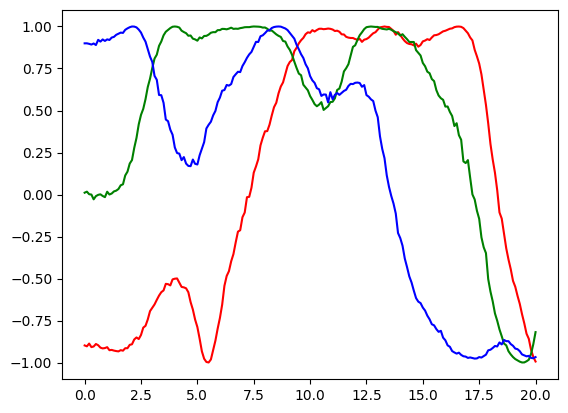

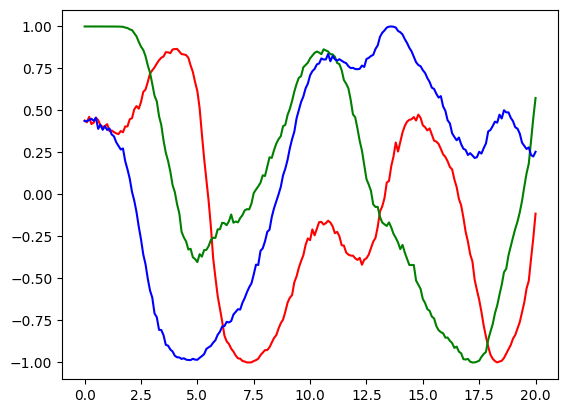

In [210]:
z0 = []
z1 = []
z2 = []

for index, row in df.iterrows():
    z0.append([row['Richtung_X_B0'], row['Richtung_Y_B0']])
    z1.append([row['Richtung_X_B1'], row['Richtung_Y_B1']])
    z2.append([row['Richtung_X_B2'], row['Richtung_Y_B2']])

t = [(i * dT) for i in range(len(df))]

z0x = [h[0] for h in z0]
z0y = [h[1] for h in z0]

z1x = [h[0] for h in z1]
z1y = [h[1] for h in z1]

z2x = [h[0] for h in z2]
z2y = [h[1] for h in z2]

plt.plot(t, z0x, label='Geschätzer Weg', linestyle='-', color='red', markersize=4)
plt.plot(t, z1x, label='Geschätzer Weg', linestyle='-', color='green', markersize=4)
plt.plot(t, z2x, label='Geschätzer Weg', linestyle='-', color='blue', markersize=4)
plt.show()


plt.plot(t, z0y, label='Geschätzer Weg', color='red', markersize=4)
plt.plot(t, z1y, label='Geschätzer Weg', linestyle='-', color='green', markersize=4)
plt.plot(t, z2y, label='Geschätzer Weg', linestyle='-', color='blue', markersize=4)
plt.show()

In [211]:

# UKF

"""
sigmas = MerweScaledSigmaPoints(n = 6, alpha = 0.1, beta = 2.0, kappa = 1.0)
ukf = UKF(dim_x = 6, dim_z = 6, fx = f_x, hx = h_x, dt = dT, points = sigmas)
ukf.x = states[0].copy() 
#std_h ** 2, std_h ** 2, 
ukf.R = np.diag([std_0 ** 2, std_0 ** 2, std_1 ** 2, std_1 ** 2, std_2 ** 2, std_2 ** 2])
ukf.Q = Q_discrete_white_noise(dim = 2, dt = dT, var = 2, block_size = 3, order_by_dim = False)
"""

sigmas = MerweScaledSigmaPoints(n=6, alpha=0.1, beta=2.0, kappa=1.0)

ukf = UKF(dim_x=6, dim_z=6, fx=f_x, hx=h_x, dt=dT, points=sigmas)
#ukf.x = states[0].copy() # ggf. kontrollieren

init_state = np.array([0, -14.9, 0, 1, 0, 0])  # [x, y, vx, vy, ax, ay]
ukf.x = init_state
ukf.Q = Q_discrete_white_noise(dim=2, dt=dT, var=2.0, block_size=3, order_by_dim=False)

"""
# Extrahiere Messdaten als Liste
zs = df[['Richtung_X_B0', 'Richtung_Y_B0', 'Richtung_X_B1', 'Richtung_Y_B1', 'Richtung_X_B2', 'Richtung_Y_B2']].values
"""

# Speichere geschätzten Zustände und Kovarianzmatrizen
uxs = []
uPs = []

# Iteriere durch jede Zeile im Df
for index, row in df.iterrows():

    # Extrahiere die Standardabweichungen für die aktuelle Messung
    std_b0 = row['STD_Grad_B0'] / 100
    std_b1 = row['STD_Grad_B1'] / 100
    std_b2 = row['STD_Grad_B2'] / 100

    # Zeige Std zwecks Korrektheit
    #print(std_b0, std_b1, std_b2)
    
    # Setze die Rauschmatrix R basierend auf den extrahierten Standardabweichungen immer neu
    ukf.R = np.diag([std_b0 ** 2, std_b0 ** 2, std_b1 ** 2, std_b1 ** 2, std_b2 ** 2, std_b2 ** 2])

    # Prüfe ob Std. in R-Matrix gesetzt werden
    # print(ukf.R)
    
    # Extrahiere den aktuellen Messvektor z
    z = np.array([
        row['Richtung_X_B0'], row['Richtung_Y_B0'],
        row['Richtung_X_B1'], row['Richtung_Y_B1'],
        row['Richtung_X_B2'], row['Richtung_Y_B2']
    ])

    # Check ob Daten korrekt eingelesen sind
    # print(z)
    
    # Vorhersage und Update mit dem aktuellen Messvektor
    ukf.predict()
    ukf.update(z)
    
    # Speichere die geschätzten Zustände und Kovarianzmatrizen
    uxs.append(ukf.x.copy())
    uPs.append(ukf.P.copy())

uxs = np.array(uxs)


In [212]:
#print(uxs)

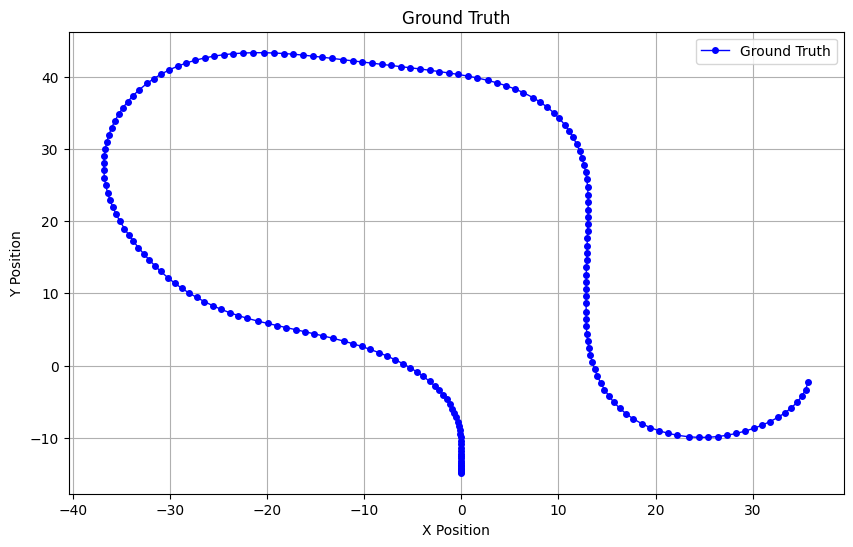

In [213]:
plt.figure(figsize=(10, 6))

plt.plot(df['X_GT'], df['Y_GT'], marker='o', linestyle='-', color='blue', markersize=4, linewidth=1, label='Ground Truth')

plt.title('Ground Truth')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)

plt.show()

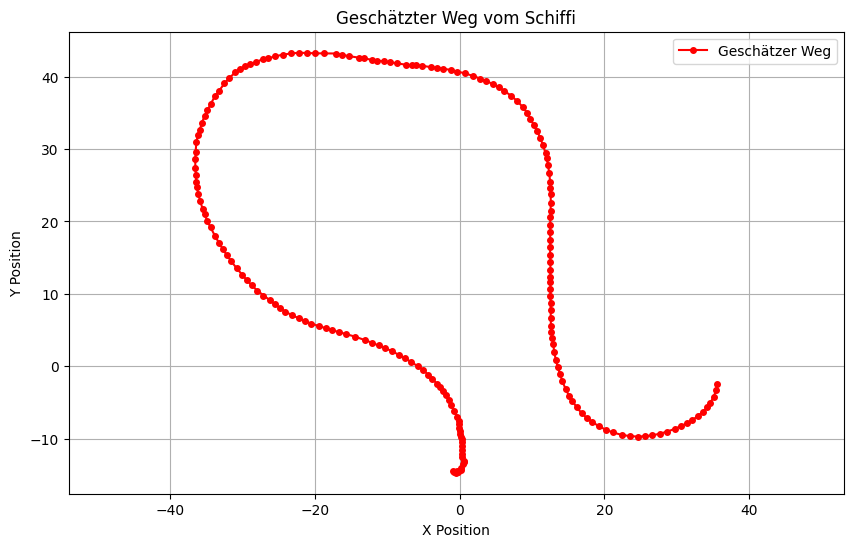

In [214]:

"""
Plot
"""
plt.figure(figsize=(10, 6))
ux_val = [s[0] for s in uxs]
uy_val = [s[1] for s in uxs]
plt.plot(ux_val, uy_val, label='Geschätzer Weg', marker='o', linestyle='-', color='red', markersize=4)

plt.title('Geschätzter Weg vom Schiffi')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)
plt.axis('equal')  # Stellt sicher, dass die Skalierung auf beiden Achsen gleich ist
plt.show()

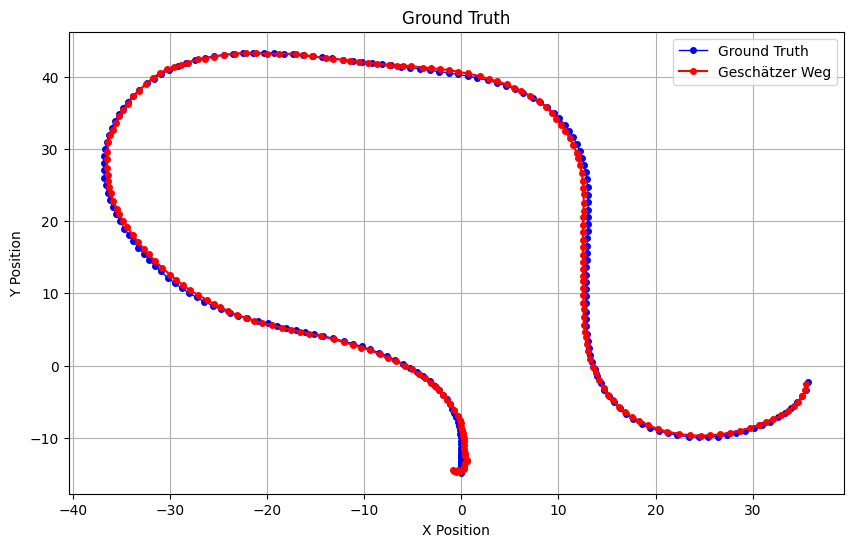

In [215]:
plt.figure(figsize=(10, 6))
plt.plot(df['X_GT'], df['Y_GT'], marker='o', linestyle='-', color='blue', markersize=4, linewidth=1, label='Ground Truth')
plt.plot(ux_val, uy_val, label='Geschätzer Weg', marker='o', linestyle='-', color='red', markersize=4)


plt.title('Ground Truth')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)

plt.show()
